In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk langgraph-prebuilt

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

### Added a lot of my own custom tools 

In [3]:
from langchain_openai import ChatOpenAI
import math

def add(a: int, b: int) -> int:
    """Add two integers.

    Args:
        a: First integer
        b: Second integer

    Returns:
        Sum of a and b
    """
    return a + b

def subtract(a: int, b: int) -> int:
    """Subtract b from a.

    Args:
        a: First integer
        b: Second integer

    Returns:
        Result of a - b
    """
    return a - b

def multiply(a: int, b: int) -> int:
    """Multiply two integers.

    Args:
        a: First integer
        b: Second integer

    Returns:
        Product of a and b
    """
    return a * b

def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: Dividend
        b: Divisor

    Returns:
        Result of a / b
    """
    return a / b

def exponent(a: int, b: int) -> int:
    """Raise a to the power of b.

    Args:
        a: Base integer
        b: Exponent integer

    Returns:
        a raised to the power b
    """
    return a ** b

def factorial(n: int) -> int:
    """Calculate factorial of n.

    Args:
        n: An integer (should be >= 0)

    Returns:
        Factorial of n
    """
    return math.factorial(n)

def modulus(a: int, b: int) -> int:
    """Compute a modulo b.

    Args:
        a: Dividend
        b: Divisor

    Returns:
        Remainder after dividing a by b
    """
    return a % b

def integer_division(a: int, b: int) -> int:
    """Integer division (floor division) of a by b.

    Args:
        a: Dividend
        b: Divisor

    Returns:
        Quotient of a // b
    """
    return a // b

tools = [
    add,
    subtract,
    multiply,
    divide,
    exponent,
    factorial,
    modulus,
    integer_division
]

llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)


### Created the standard graph


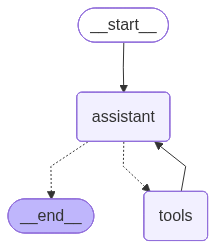

In [4]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(checkpointer=MemorySaver())

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

### NORMAL RUN

Created my own example :

In [5]:
# Input
initial_input = {"messages": HumanMessage(content="RAISE 5 TO THE POWER 2 AND THEN MULTIPLY BY 3")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

RAISE 5 TO THE POWER 2 AND THEN MULTIPLY BY 3
================================== Ai Message ==================================
Tool Calls:
  exponent (call_12JCjlgrBQZSoahgG7JoqCXG)
 Call ID: call_12JCjlgrBQZSoahgG7JoqCXG
  Args:
    a: 5
    b: 2
  multiply (call_hOajNRYTfSyckOdmlU0uP28g)
 Call ID: call_hOajNRYTfSyckOdmlU0uP28g
  Args:
    a: 5
    b: 0
================================= Tool Message =================================
Name: multiply

0
================================== Ai Message ==================================
Tool Calls:
  multiply (call_ax5uyODG4PGBCdun9Gr3oyAz)
 Call ID: call_ax5uyODG4PGBCdun9Gr3oyAz
  Args:
    a: 25
    b: 3
================================= Tool Message =================================
Name: multiply

75
================================== Ai Message ==================================

When you raise 5 to the power of 2, you get 25. Then, multiplying 25 by 3 giv

## LOOKING IN THE PAST STATES 

In [6]:
all_states = [s for s in graph.get_state_history(thread)]
len(all_states)


7

### A LOOK AT THE PAST STATES AND ALSO THE CURRENT STATE FOR COMPARISION

In [7]:
all_states[0]

StateSnapshot(values={'messages': [HumanMessage(content='RAISE 5 TO THE POWER 2 AND THEN MULTIPLY BY 3', additional_kwargs={}, response_metadata={}, id='ddf17290-df8f-4978-95ad-c2c3291bebd4'), AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 51, 'prompt_tokens': 294, 'total_tokens': 345, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_65564d8ba5', 'id': 'chatcmpl-CVLyCtQJaKIvE8KMFU5Y7vXbG1tYw', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--9c0ac2bc-a281-4ade-881d-14aa14ad2f02-0', tool_calls=[{'name': 'exponent', 'args': {'a': 5, 'b': 2}, 'id': 'call_12JCjlgrBQZSoahgG7JoqCXG', 'type': 'tool_call'}, {'name': 'multiply', 'args': {'a': 5, '

In [8]:
all_states[-1]

StateSnapshot(values={'messages': []}, next=('__start__',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b3604-71cb-6108-bfff-1530310f3b37'}}, metadata={'source': 'input', 'step': -1, 'parents': {}}, created_at='2025-10-27T18:10:53.978033+00:00', parent_config=None, tasks=(PregelTask(id='9c1f1292-07e3-08f6-f1eb-6eae0f1ca344', name='__start__', path=('__pregel_pull', '__start__'), error=None, interrupts=(), state=None, result={'messages': HumanMessage(content='RAISE 5 TO THE POWER 2 AND THEN MULTIPLY BY 3', additional_kwargs={}, response_metadata={})}),), interrupts=())

In [9]:
all_states[-2]

StateSnapshot(values={'messages': [HumanMessage(content='RAISE 5 TO THE POWER 2 AND THEN MULTIPLY BY 3', additional_kwargs={}, response_metadata={}, id='ddf17290-df8f-4978-95ad-c2c3291bebd4')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b3604-71cb-6f9a-8000-091f2c224028'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-10-27T18:10:53.978406+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b3604-71cb-6108-bfff-1530310f3b37'}}, tasks=(PregelTask(id='3e51c69b-de95-262e-d2f8-ed39637b3691', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 51, 'prompt_tokens': 294, 'total_tokens': 345, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasonin

In [10]:
all_states[-3]

StateSnapshot(values={'messages': [HumanMessage(content='RAISE 5 TO THE POWER 2 AND THEN MULTIPLY BY 3', additional_kwargs={}, response_metadata={}, id='ddf17290-df8f-4978-95ad-c2c3291bebd4'), AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 51, 'prompt_tokens': 294, 'total_tokens': 345, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_65564d8ba5', 'id': 'chatcmpl-CVLyCtQJaKIvE8KMFU5Y7vXbG1tYw', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--9c0ac2bc-a281-4ade-881d-14aa14ad2f02-0', tool_calls=[{'name': 'exponent', 'args': {'a': 5, 'b': 2}, 'id': 'call_12JCjlgrBQZSoahgG7JoqCXG', 'type': 'tool_call'}, {'name': 'multiply', 'args': {'a': 5, '

In [11]:
all_states[-4]

StateSnapshot(values={'messages': [HumanMessage(content='RAISE 5 TO THE POWER 2 AND THEN MULTIPLY BY 3', additional_kwargs={}, response_metadata={}, id='ddf17290-df8f-4978-95ad-c2c3291bebd4'), AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 51, 'prompt_tokens': 294, 'total_tokens': 345, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_65564d8ba5', 'id': 'chatcmpl-CVLyCtQJaKIvE8KMFU5Y7vXbG1tYw', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--9c0ac2bc-a281-4ade-881d-14aa14ad2f02-0', tool_calls=[{'name': 'exponent', 'args': {'a': 5, 'b': 2}, 'id': 'call_12JCjlgrBQZSoahgG7JoqCXG', 'type': 'tool_call'}, {'name': 'multiply', 'args': {'a': 5, '

## REPLAYING 

#### CHOSE A STATE TO REPLAY : 


In [12]:
to_replay = all_states[-3]
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='RAISE 5 TO THE POWER 2 AND THEN MULTIPLY BY 3', additional_kwargs={}, response_metadata={}, id='ddf17290-df8f-4978-95ad-c2c3291bebd4'), AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 51, 'prompt_tokens': 294, 'total_tokens': 345, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_65564d8ba5', 'id': 'chatcmpl-CVLyCtQJaKIvE8KMFU5Y7vXbG1tYw', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--9c0ac2bc-a281-4ade-881d-14aa14ad2f02-0', tool_calls=[{'name': 'exponent', 'args': {'a': 5, 'b': 2}, 'id': 'call_12JCjlgrBQZSoahgG7JoqCXG', 'type': 'tool_call'}, {'name': 'multiply', 'args': {'a': 5, '

In [13]:
to_replay.values

{'messages': [HumanMessage(content='RAISE 5 TO THE POWER 2 AND THEN MULTIPLY BY 3', additional_kwargs={}, response_metadata={}, id='ddf17290-df8f-4978-95ad-c2c3291bebd4'),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 51, 'prompt_tokens': 294, 'total_tokens': 345, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_65564d8ba5', 'id': 'chatcmpl-CVLyCtQJaKIvE8KMFU5Y7vXbG1tYw', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--9c0ac2bc-a281-4ade-881d-14aa14ad2f02-0', tool_calls=[{'name': 'exponent', 'args': {'a': 5, 'b': 2}, 'id': 'call_12JCjlgrBQZSoahgG7JoqCXG', 'type': 'tool_call'}, {'name': 'multiply', 'args': {'a': 5, 'b': 0}, 'id': 'call

In [14]:
to_replay.next

('tools',)

In [15]:
to_replay.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b3604-9761-6674-8001-465f526801cf'}}

### it will js replay instead of running again 

In [16]:
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  exponent (call_12JCjlgrBQZSoahgG7JoqCXG)
 Call ID: call_12JCjlgrBQZSoahgG7JoqCXG
  Args:
    a: 5
    b: 2
  multiply (call_hOajNRYTfSyckOdmlU0uP28g)
 Call ID: call_hOajNRYTfSyckOdmlU0uP28g
  Args:
    a: 5
    b: 0
================================= Tool Message =================================
Name: multiply

0
================================== Ai Message ==================================
Tool Calls:
  multiply (call_IwkPatVHoUN20XwzHDinPq7K)
 Call ID: call_IwkPatVHoUN20XwzHDinPq7K
  Args:
    a: 25
    b: 3
================================= Tool Message =================================
Name: multiply

75
================================== Ai Message ==================================

Raising 5 to the power of 2 gives 25, and multiplying 25 by 3 gives 75.


### replayed all the rest of the states, using direct method

In [17]:
to_replay = all_states[-4]

for event in graph.stream(None, to_replay.config, stream_mode="values"):
    event['messages'][-1].pretty_print()


================================= Tool Message =================================
Name: multiply

0
================================== Ai Message ==================================
Tool Calls:
  multiply (call_V9u6zkdsKoTg7NU1zyZ5O8AA)
 Call ID: call_V9u6zkdsKoTg7NU1zyZ5O8AA
  Args:
    a: 25
    b: 3
================================= Tool Message =================================
Name: multiply

75
================================== Ai Message ==================================

Raising 5 to the power of 2 gives 25, and multiplying it by 3 results in 75.


In [18]:
to_replay = all_states[-2]

for event in graph.stream(None, to_replay.config, stream_mode="values"):
    event['messages'][-1].pretty_print()


================================ Human Message =================================

RAISE 5 TO THE POWER 2 AND THEN MULTIPLY BY 3
================================== Ai Message ==================================
Tool Calls:
  exponent (call_JmOyHwAb2mNrK2gaSddM6jvS)
 Call ID: call_JmOyHwAb2mNrK2gaSddM6jvS
  Args:
    a: 5
    b: 2
  multiply (call_SyHR6CTpNbPup5ilgLQ8KFDn)
 Call ID: call_SyHR6CTpNbPup5ilgLQ8KFDn
  Args:
    a: 25
    b: 3
================================= Tool Message =================================
Name: multiply

75
================================== Ai Message ==================================

First, 5 raised to the power of 2 is \( 25 \). Then, multiplying 25 by 3 gives you \( 75 \).


In [19]:
to_replay = all_states[0]

for event in graph.stream(None, to_replay.config, stream_mode="values"):
    event['messages'][-1].pretty_print()


================================== Ai Message ==================================

When you raise 5 to the power of 2, you get 25. Then, multiplying 25 by 3 gives you 75.


## FORKING : 

In [20]:
to_fork = all_states[-2]
to_fork.values["messages"]

[HumanMessage(content='RAISE 5 TO THE POWER 2 AND THEN MULTIPLY BY 3', additional_kwargs={}, response_metadata={}, id='ddf17290-df8f-4978-95ad-c2c3291bebd4')]

In [21]:
to_fork.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b3604-71cb-6f9a-8000-091f2c224028'}}

In [22]:
fork_config = graph.update_state(
    to_fork.config,
    {"messages": [HumanMessage(content='INTEGER DIVIDE 13 BY 4 AND THEN ADD 2 ', 
                               id=to_fork.values["messages"][0].id)]},
)

THIS REMAINED SAME, VERY IMP TO NOTICE 

In [23]:
fork_config


{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b3605-0b8e-6a4c-8001-b0e8dbcc0a10'}}

In [24]:
all_states = [state for state in graph.get_state_history(thread) ]
all_states[0].values["messages"]

[HumanMessage(content='INTEGER DIVIDE 13 BY 4 AND THEN ADD 2 ', additional_kwargs={}, response_metadata={}, id='ddf17290-df8f-4978-95ad-c2c3291bebd4'),
 AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 51, 'prompt_tokens': 294, 'total_tokens': 345, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_65564d8ba5', 'id': 'chatcmpl-CVLyCtQJaKIvE8KMFU5Y7vXbG1tYw', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--9c0ac2bc-a281-4ade-881d-14aa14ad2f02-0', tool_calls=[{'name': 'exponent', 'args': {'a': 5, 'b': 2}, 'id': 'call_12JCjlgrBQZSoahgG7JoqCXG', 'type': 'tool_call'}, {'name': 'multiply', 'args': {'a': 5, 'b': 0}, 'id': 'call_hOajNRYTfSyckOdmlU0u

In [25]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='INTEGER DIVIDE 13 BY 4 AND THEN ADD 2 ', additional_kwargs={}, response_metadata={}, id='ddf17290-df8f-4978-95ad-c2c3291bebd4'), AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 51, 'prompt_tokens': 294, 'total_tokens': 345, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_65564d8ba5', 'id': 'chatcmpl-CVLyCtQJaKIvE8KMFU5Y7vXbG1tYw', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--9c0ac2bc-a281-4ade-881d-14aa14ad2f02-0', tool_calls=[{'name': 'exponent', 'args': {'a': 5, 'b': 2}, 'id': 'call_12JCjlgrBQZSoahgG7JoqCXG', 'type': 'tool_call'}, {'name': 'multiply', 'args': {'a': 5, 'b': 0},

In [26]:
for event in graph.stream(None, fork_config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  exponent (call_12JCjlgrBQZSoahgG7JoqCXG)
 Call ID: call_12JCjlgrBQZSoahgG7JoqCXG
  Args:
    a: 5
    b: 2
  multiply (call_hOajNRYTfSyckOdmlU0uP28g)
 Call ID: call_hOajNRYTfSyckOdmlU0uP28g
  Args:
    a: 5
    b: 0
================================= Tool Message =================================
Name: multiply

0
================================== Ai Message ==================================
Tool Calls:
  integer_division (call_NbX3DNhiAqXCFoCe4BEwloQP)
 Call ID: call_NbX3DNhiAqXCFoCe4BEwloQP
  Args:
    a: 13
    b: 4
================================= Tool Message =================================
Name: integer_division

3
================================== Ai Message ==================================
Tool Calls:
  add (call_4jPH34dIF05gGIT4kR2MbgZ8)
 Call ID: call_4jPH34dIF05gGIT4kR2MbgZ8
  Args:
    a: 3
    b: 2
================================= Tool Message ============================

In [27]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='INTEGER DIVIDE 13 BY 4 AND THEN ADD 2 ', additional_kwargs={}, response_metadata={}, id='ddf17290-df8f-4978-95ad-c2c3291bebd4'), AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 51, 'prompt_tokens': 294, 'total_tokens': 345, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_65564d8ba5', 'id': 'chatcmpl-CVLyCtQJaKIvE8KMFU5Y7vXbG1tYw', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--9c0ac2bc-a281-4ade-881d-14aa14ad2f02-0', tool_calls=[{'name': 'exponent', 'args': {'a': 5, 'b': 2}, 'id': 'call_12JCjlgrBQZSoahgG7JoqCXG', 'type': 'tool_call'}, {'name': 'multiply', 'args': {'a': 5, 'b': 0},

### short method

In [28]:
to_fork = all_states[-2]
fork_config = graph.update_state(
    to_fork.config,
    {"messages": [HumanMessage(content='subtract 10 from 50', 
                               id=to_fork.values["messages"][0].id)]},)
all_states = [state for state in graph.get_state_history(thread) ]
for event in graph.stream(None, fork_config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  exponent (call_12JCjlgrBQZSoahgG7JoqCXG)
 Call ID: call_12JCjlgrBQZSoahgG7JoqCXG
  Args:
    a: 5
    b: 2
  multiply (call_hOajNRYTfSyckOdmlU0uP28g)
 Call ID: call_hOajNRYTfSyckOdmlU0uP28g
  Args:
    a: 5
    b: 0
================================= Tool Message =================================
Name: multiply

0
================================== Ai Message ==================================
Tool Calls:
  subtract (call_V6wy36hHVKcFKIBR6FszzsXN)
 Call ID: call_V6wy36hHVKcFKIBR6FszzsXN
  Args:
    a: 50
    b: 10
================================= Tool Message =================================
Name: subtract

40
================================== Ai Message ==================================

Subtracting 10 from 50 gives you 40.


# time travel using langgraph api

In [29]:
from langgraph_sdk import get_client
client = get_client(url="http://127.0.0.1:2024")

## REPLAYING : 


DEFINED A FRESH NEW NODE : 

In [30]:
initial_input = {"messages": HumanMessage(content="RAISE 7 TO THE POWER 3 AND THEN SUBTRACT 10")}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id = "agent",
    input=initial_input,
    stream_mode="updates",
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

--------------------Assistant Node--------------------
{'content': '', 'additional_kwargs': {'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 18, 'prompt_tokens': 293, 'total_tokens': 311, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a788c5aef0', 'id': 'chatcmpl-CVLyWkLtWzYZwavHK8w9Pl5VerKe7', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'lc_run--2ec51a9f-632d-450a-8d5d-606e35756f2e-0', 'tool_calls': [{'name': 'exponent', 'args': {'a': 7, 'b': 3}, 'id': 'call_k597GqF2W2Sfuzsdiq5ImRNk', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 293, 'output_tokens': 18, 'total_tokens': 311, 'input_token_details': {'audio': 0

In [31]:
states = await client.threads.get_history(thread['thread_id'])


In [32]:
to_replay = states[-2]
to_replay

{'values': {'messages': [{'content': 'RAISE 7 TO THE POWER 3 AND THEN SUBTRACT 10',
    'additional_kwargs': {},
    'response_metadata': {},
    'type': 'human',
    'name': None,
    'id': '050a4fc4-9144-4db3-8f1e-71bbca864629'}]},
 'next': ['assistant'],
 'tasks': [{'id': 'cb5557d9-e482-becc-c5c0-3049a6420bfe',
   'name': 'assistant',
   'path': ['__pregel_pull', 'assistant'],
   'error': None,
   'interrupts': [],
   'checkpoint': None,
   'state': None,
   'result': {'messages': [{'content': '',
      'additional_kwargs': {'refusal': None},
      'response_metadata': {'token_usage': {'completion_tokens': 18,
        'prompt_tokens': 293,
        'total_tokens': 311,
        'completion_tokens_details': {'accepted_prediction_tokens': 0,
         'audio_tokens': 0,
         'reasoning_tokens': 0,
         'rejected_prediction_tokens': 0},
        'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}},
       'model_provider': 'openai',
       'model_name': 'gpt-4o-2024-08

### STREAMED USING CHECKPOINT ID 

In [33]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="values",
    checkpoint_id=to_replay['checkpoint_id']
):      
    print(f"Receiving new event of type: {chunk.event}...")
    print(chunk.data)
    print("\n\n")

Receiving new event of type: metadata...
{'run_id': '019a26de-1759-704b-9b2f-ea7887227154', 'attempt': 1}



Receiving new event of type: values...
{'messages': [{'content': 'RAISE 7 TO THE POWER 3 AND THEN SUBTRACT 10', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '050a4fc4-9144-4db3-8f1e-71bbca864629'}]}



Receiving new event of type: values...
{'messages': [{'content': 'RAISE 7 TO THE POWER 3 AND THEN SUBTRACT 10', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '050a4fc4-9144-4db3-8f1e-71bbca864629'}, {'content': '', 'additional_kwargs': {'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 51, 'prompt_tokens': 293, 'total_tokens': 344, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name

In [34]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="updates",
    checkpoint_id=to_replay['checkpoint_id']
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

--------------------Assistant Node--------------------
{'content': '', 'additional_kwargs': {'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 18, 'prompt_tokens': 293, 'total_tokens': 311, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a788c5aef0', 'id': 'chatcmpl-CVLyftupupFPXd986Ve34xWicukjN', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'lc_run--baad5ec1-ac39-4ba7-a188-2d080f5319f7-0', 'tool_calls': [{'name': 'exponent', 'args': {'a': 7, 'b': 3}, 'id': 'call_O5uQtLWrKPhMtDQUSMf6ANcy', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 293, 'output_tokens': 18, 'total_tokens': 311, 'input_token_details': {'audio': 0

### replayed  all the other states as well, using direct method

In [35]:
to_replay = states[-1]
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="updates",
    checkpoint_id=to_replay['checkpoint_id']
):      
    print(f"Receiving new event of type: {chunk.event}...")
    print(chunk.data)
    print("\n\n")

Receiving new event of type: metadata...
{'run_id': '019a26de-35a0-70b9-99bf-4fa39870ec08', 'attempt': 1}



Receiving new event of type: updates...
{'assistant': {'messages': [{'content': '', 'additional_kwargs': {'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 51, 'prompt_tokens': 293, 'total_tokens': 344, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a788c5aef0', 'id': 'chatcmpl-CVLyjBkqcZ4HdrQzp5bA8fwTUuJLI', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'lc_run--5e40c8ed-509a-462a-80f5-02d063ed6830-0', 'tool_calls': [{'name': 'exponent', 'args': {'a': 7, 'b': 3}, 'id': 'call_FIMDQYlG47eHG5u1GHESHp7L', 'type': 'tool_call'}, {'name': 'subtract', 

In [36]:
to_replay = states[-3]
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="updates",
    checkpoint_id=to_replay['checkpoint_id']
):      
    print(f"Receiving new event of type: {chunk.event}...")
    print(chunk.data)
    print("\n\n")

Receiving new event of type: metadata...
{'run_id': '019a26de-438f-70dc-8012-61a569c8db15', 'attempt': 1}



Receiving new event of type: updates...
{'tools': {'messages': [{'content': '343', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'tool', 'name': 'exponent', 'id': '28c5204f-0866-46bd-a95e-003d0ca94fdf', 'tool_call_id': 'call_k597GqF2W2Sfuzsdiq5ImRNk', 'artifact': None, 'status': 'success'}]}}



Receiving new event of type: updates...
{'assistant': {'messages': [{'content': '', 'additional_kwargs': {'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 17, 'prompt_tokens': 320, 'total_tokens': 337, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a788c5aef0', 'id': 'chatcmpl-CVLymUSZGNWOajZjFu4P329pBYGc

In [37]:
to_replay = states[-4]
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="updates",
    checkpoint_id=to_replay['checkpoint_id']
):      
    print(f"Receiving new event of type: {chunk.event}...")
    print(chunk.data)
    print("\n\n")

Receiving new event of type: metadata...
{'run_id': '019a26de-4fd8-7637-a294-b7c787038840', 'attempt': 1}



Receiving new event of type: updates...
{'assistant': {'messages': [{'content': '', 'additional_kwargs': {'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 17, 'prompt_tokens': 320, 'total_tokens': 337, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a788c5aef0', 'id': 'chatcmpl-CVLyp2ysSY4Aexar7krFZxxn3L8qc', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'lc_run--8e3368ee-0d82-4a20-a645-18d418d7e2fe-0', 'tool_calls': [{'name': 'subtract', 'args': {'a': 343, 'b': 10}, 'id': 'call_Hb8XloKCm9pqgkz4tjF9G65r', 'type': 'tool_call'}], 'invalid_tool_cal

## forking 

In [38]:
initial_input = {"messages": HumanMessage(content="RAISE 4 TO THE POWER 2, SUBTRACT 11 AND THEN FACTORIAL THIS OUTPUT")}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=initial_input,
    stream_mode="updates",
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

--------------------Assistant Node--------------------
{'content': '', 'additional_kwargs': {'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 18, 'prompt_tokens': 299, 'total_tokens': 317, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a788c5aef0', 'id': 'chatcmpl-CVLytRurBXBLNR0ZUPhrXd3qTCKpM', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'lc_run--85ee932c-7f8f-4877-acd6-3adc1cad18a1-0', 'tool_calls': [{'name': 'exponent', 'args': {'a': 4, 'b': 2}, 'id': 'call_XoNKR1r163HfMG7ZCpV7Gf8S', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 299, 'output_tokens': 18, 'total_tokens': 317, 'input_token_details': {'audio': 0

In [39]:
states = await client.threads.get_history(thread['thread_id'])


In [40]:
to_fork = states[-2]


### used the checkpoint id 

In [41]:
forked_input = {"messages": HumanMessage(content="raise 6 to the power 2",
                                         id=to_fork['values']['messages'][0]['id'])}

forked_config = await client.threads.update_state(
    thread["thread_id"],
    forked_input,
    checkpoint_id=to_fork['checkpoint_id']
)

In [42]:
states = await client.threads.get_history(thread['thread_id'])
states[0]

{'values': {'messages': [{'content': 'raise 6 to the power 2',
    'additional_kwargs': {},
    'response_metadata': {},
    'type': 'human',
    'name': None,
    'id': 'ca56b71e-5da8-40a4-aa51-7b584fc339bf'},
   {'content': '',
    'additional_kwargs': {'refusal': None},
    'response_metadata': {'token_usage': {'completion_tokens': 18,
      'prompt_tokens': 299,
      'total_tokens': 317,
      'completion_tokens_details': {'accepted_prediction_tokens': 0,
       'audio_tokens': 0,
       'reasoning_tokens': 0,
       'rejected_prediction_tokens': 0},
      'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}},
     'model_provider': 'openai',
     'model_name': 'gpt-4o-2024-08-06',
     'system_fingerprint': 'fp_a788c5aef0',
     'id': 'chatcmpl-CVLytRurBXBLNR0ZUPhrXd3qTCKpM',
     'service_tier': 'default',
     'finish_reason': 'tool_calls',
     'logprobs': None},
    'type': 'ai',
    'name': None,
    'id': 'lc_run--85ee932c-7f8f-4877-acd6-3adc1cad18a1-0',
    'to

### WE PASSED IN THE CHECKPOINT ID TO RUN IT 

In [43]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="updates",
    checkpoint_id=forked_config['checkpoint_id']
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

--------------------Tools Node--------------------
{'content': '16', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'tool', 'name': 'exponent', 'id': 'c32481e9-3afa-469e-bc57-3b7ac1f385ff', 'tool_call_id': 'call_XoNKR1r163HfMG7ZCpV7Gf8S', 'artifact': None, 'status': 'success'}
--------------------Assistant Node--------------------
{'content': 'The result of raising 6 to the power of 2 is 36.', 'additional_kwargs': {'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 17, 'prompt_tokens': 313, 'total_tokens': 330, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a788c5aef0', 'id': 'chatcmpl-CVLyzgQVBpi0DsYWXc2kTpzOaYrxy', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, 'type': 'ai', 'name

### direct method

In [44]:
to_fork = states[-2]
forked_input = {"messages": HumanMessage(content="subtract 20 from 100",
                                         id=to_fork['values']['messages'][0]['id'])}

forked_config = await client.threads.update_state(
    thread["thread_id"],
    forked_input,
    checkpoint_id=to_fork['checkpoint_id']
)
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="updates",
    checkpoint_id=forked_config['checkpoint_id']
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

--------------------Tools Node--------------------
{'content': '16', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'tool', 'name': 'exponent', 'id': 'e4b11848-48c9-4c4a-aa5b-8da672934e88', 'tool_call_id': 'call_XoNKR1r163HfMG7ZCpV7Gf8S', 'artifact': None, 'status': 'success'}
--------------------Assistant Node--------------------
{'content': '', 'additional_kwargs': {'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 17, 'prompt_tokens': 311, 'total_tokens': 328, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a788c5aef0', 'id': 'chatcmpl-CVLz0ANTzZgFcsdhkN4VUFD9ckCuL', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'lc_run--e351f726-772e-49d1

# FORKING IN LANGSMITH STUDIO : 

### I ran this graph and gave a simple command of addinf two numbers, after that when it interrupted after the assisstant, I had the option to alter the state and change the input values:

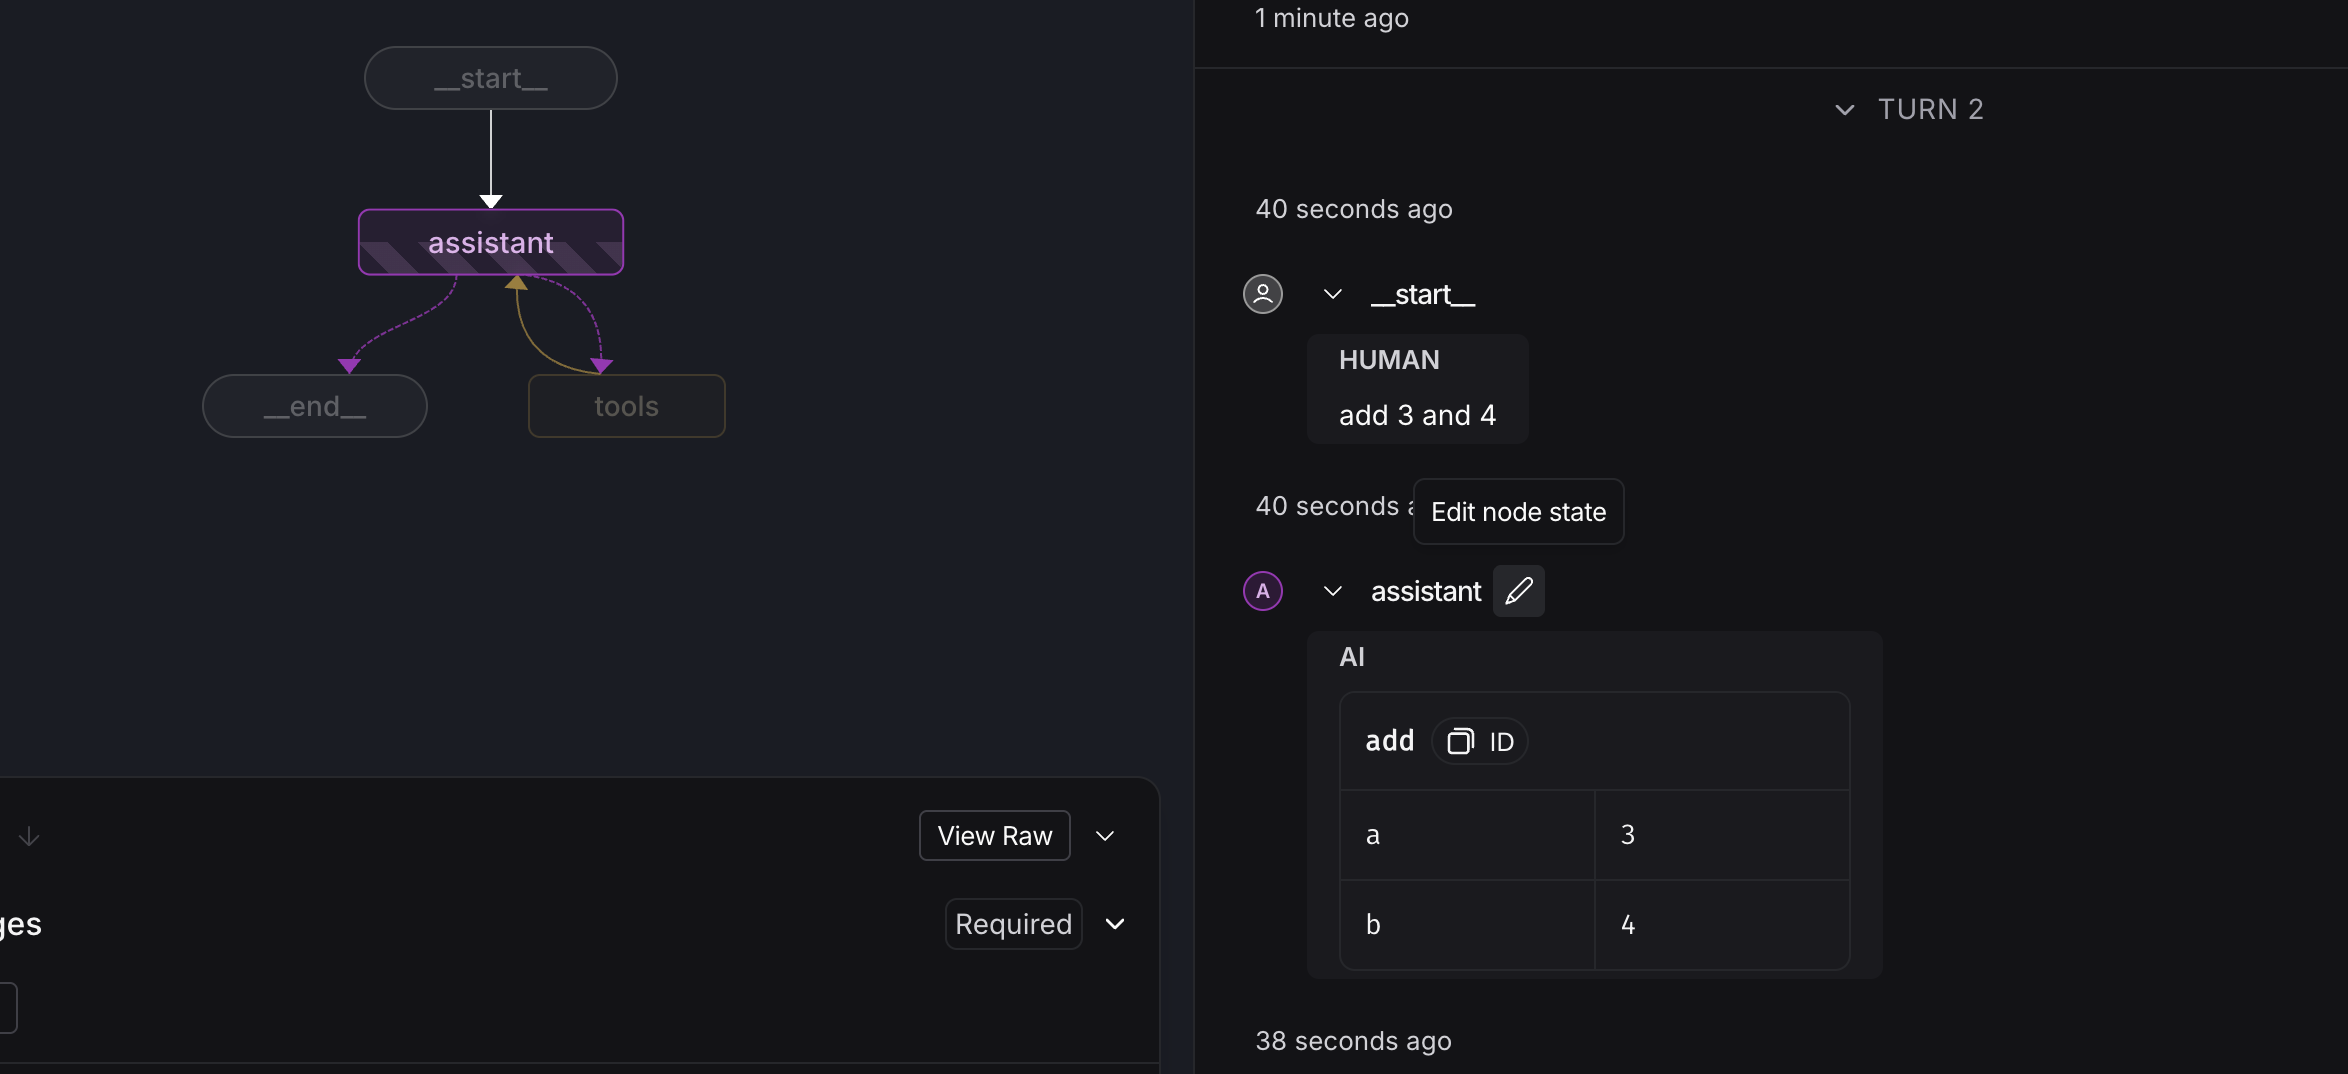

### I clicked on the edit note state, option and changed the value fo 3 to 8 in this dialog box : 
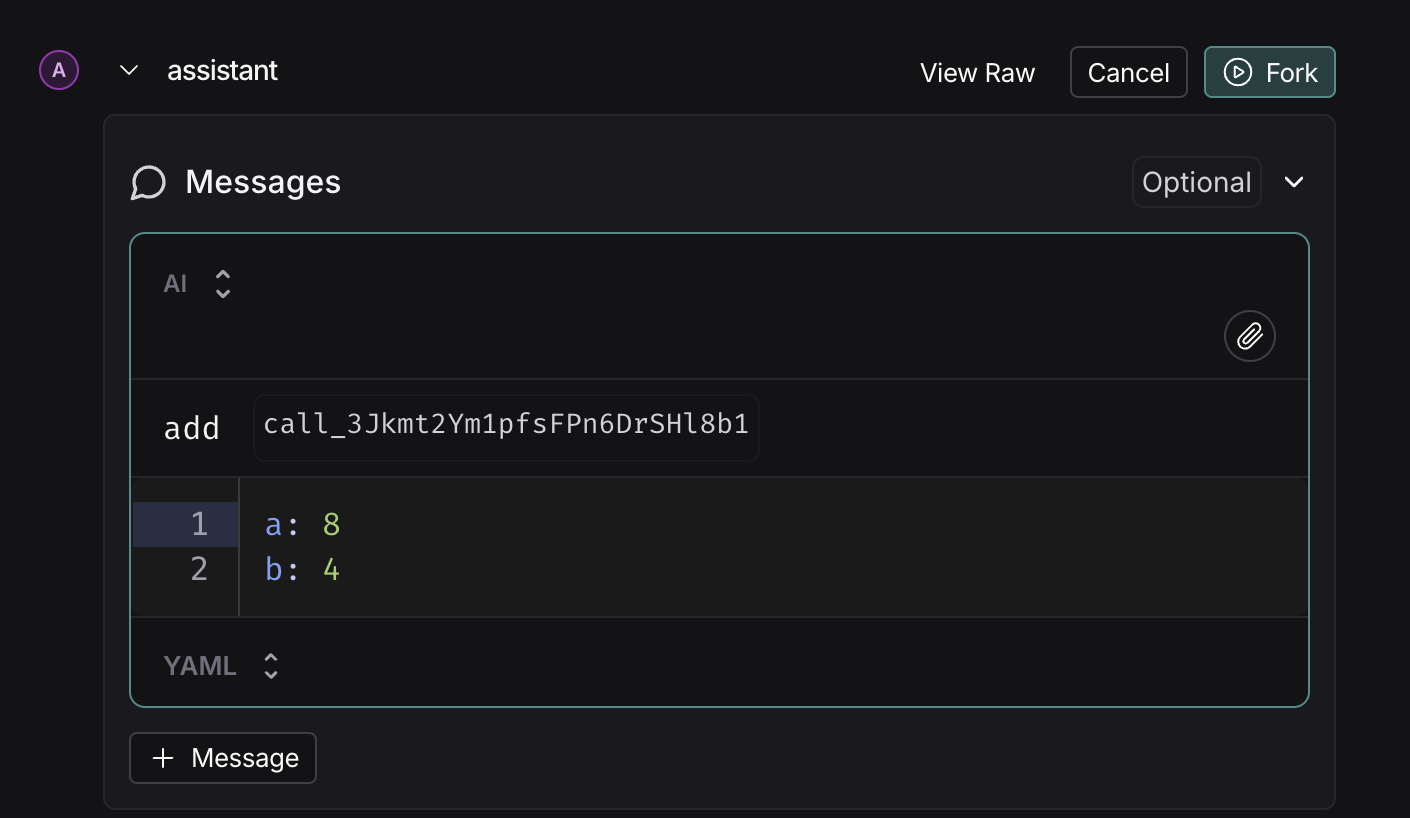

### When i clicked on fork i could see the changed output : 

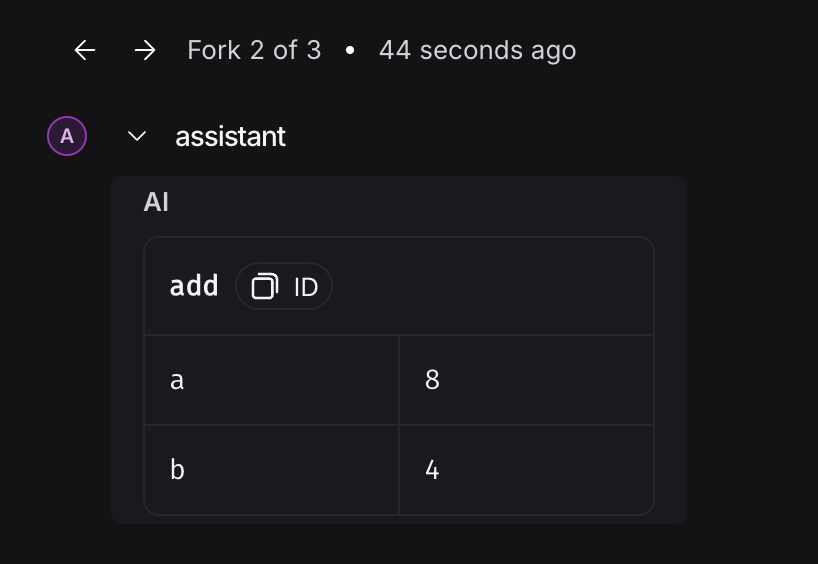

### I also added a 3rd fork for this state :

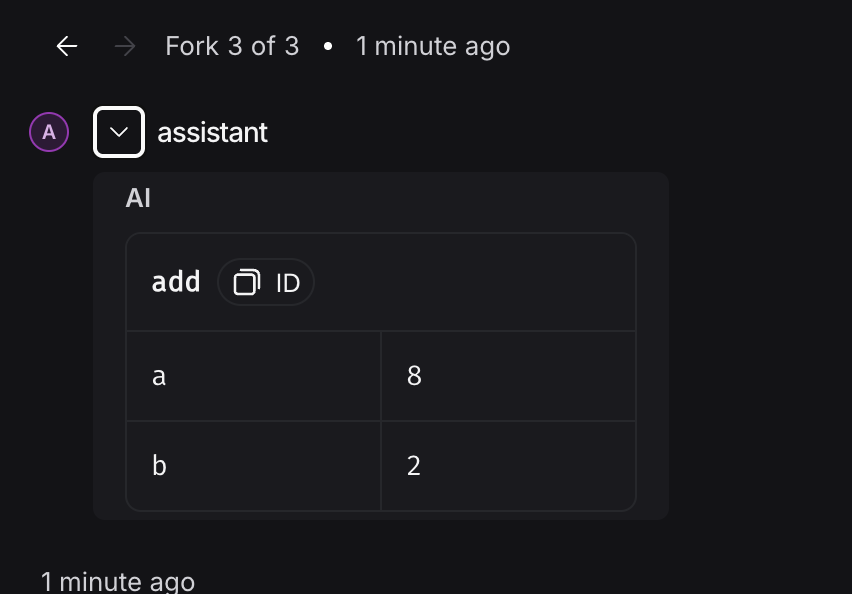

### now for each fork we can see what would have been the trajectories with these inputs, this might seem unncessary in this example but for complex graphs this is extrememly helpful